# **Workflow: Reveal raw thermal images**

## **1. Visualizing Raw thermal images**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from scipy.interpolate import KroghInterpolator

In [ ]:
cali_path = r'calibration_set_1.hdf5'
scene1_path = r'scene.hdf5'
scene2_path = r'scene2.hdf5'
scene3_path = r'scene3.hdf5'

In [ ]:
data_calibration = pd.read_hdf(cali_path)

In [ ]:
data_scene1 = pd.read_hdf(scene1_path)
data_scene2 = pd.read_hdf(scene2_path)
data_scene3 = pd.read_hdf(scene3_path)

### **1.1 Display the images**

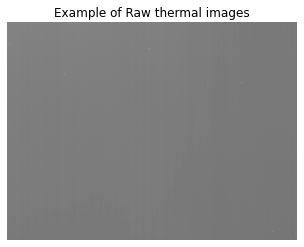

In [ ]:
image = data_calibration['image']

plt.imshow(image.iloc[0], cmap='gray')
plt.title("Example of Raw thermal images")
plt.axis('off')
plt.show()

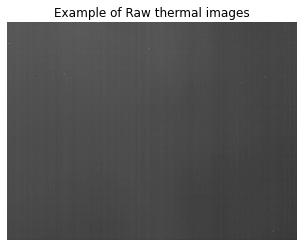

In [ ]:
scene1_image = data_scene1['image']
scene2_image = data_scene2['image']
scene3_image = data_scene3['image']

plt.imshow(scene1_image.iloc[149], cmap='gray')
plt.title("Example of Raw thermal images")
plt.axis('off')
plt.show()

## **2. Processing data (extract usefull information)**

**The usefull columns of the dataframes are**

`image` : the RAW image (numpy array)

`cint`, `gsk`, `gsk_volt`, `tint`, `gfid` : some electronics parameters

`vtemp_plot` : tension (V) of a camera temperature sensor

`vtemp_ghostline`: numeric version of `vtemp_plot`

`t_cn` : black body temperature (if applicable)

`t_etuve` : measured hoven temperature

`t_etuve_set` : set hoven temperature

`t_fpa` : converted `vtemp_plot` into degree °C

`timestamp` : time

`date` : formated version of timestamp

`framerate` : camera framerate (Hz)

`brms` : the temporal standard deviation image of the pixels (temporal noise) (if applicable).



### **2.1 Check dataset's column names**

In [ ]:
column_names = data_scene1.columns

In [ ]:
print(column_names)

Index(['index', 'cint', 'gsk', 'gsk_volt', 'tint', 'gfid', 'vtemp_plot',
       'vtemp_ghostline', 't_cn', 't_etuve', 't_etuve_set', 't_fpa',
       'ghostline', 'timestamp', 'run', 'date', 'framerate', 'scene_t_dynamic',
       'scene_type', 'camera_id', 'camera_f_number', 'camera_focal_length',
       'sensor_id', 'position_platine', 'image_kind', 'image_kind_user',
       'image', 'brms'],
      dtype='object')


### **2.2 Extract useful columns**

In [ ]:
vtemp_plot = data_calibration['vtemp_plot'] # slightly changing
vtemp_ghostline = data_calibration['vtemp_ghostline']
t_cn = data_calibration['t_cn'].values
t_e = data_calibration['t_etuve']
t_e_s = data_calibration['t_etuve_set']
t_fpa = data_calibration['t_fpa'].values


t_fpa_s1 = data_scene1['t_fpa'].values
t_fpa_s2 = data_scene2['t_fpa'].values
t_fpa_s3 = data_scene3['t_fpa'].values

### **2.3 Visualizing the data related to temperature**

In [ ]:
image_mean_list = []

for i in image:
    image_mean = np.mean(i)

    image_mean_list.append(image_mean)

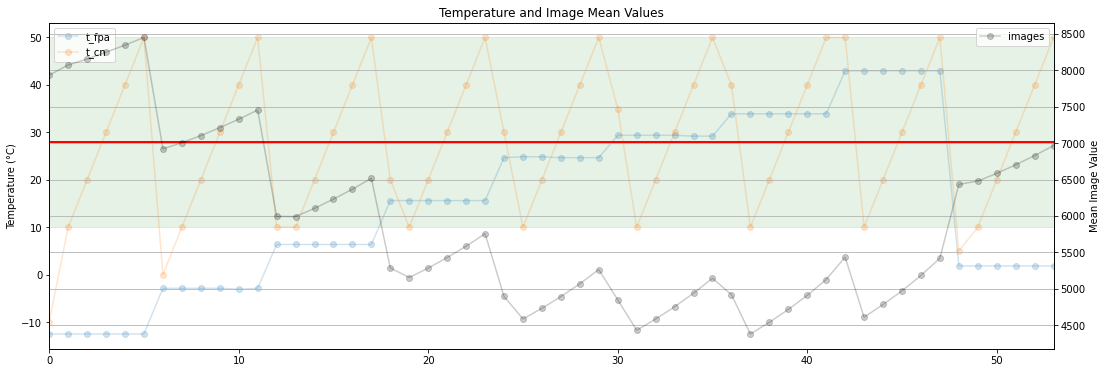

In [ ]:
plt.figure(figsize=(18,6))

ax1 = plt.gca()
ax1.plot(t_fpa, marker='o', linestyle='-', label='t_fpa', alpha = 0.2)
ax1.plot(t_cn, marker='o', linestyle='-', label='t_cn', alpha = 0.2)
ax1.set_ylabel('Temperature (°C)')
ax1.legend(loc='upper left')

ax1.axhline(y=28, color='red', linestyle='-', linewidth=2, label='Target Temperature 27.5°C')
ax1.axhspan(10, 50, color='green', alpha=0.1)

ax2 = ax1.twinx()
ax2.plot(image_mean_list, color = 'black', marker='o', linestyle='-', label='images', alpha = 0.2)
ax2.set_ylabel('Mean Image Value')
ax2.legend(loc='upper right')

plt.xlim(0,53)
plt.title('Temperature and Image Mean Values')
plt.grid(True)
plt.show()

In [ ]:
t_fpa

array([-12.4944 , -12.4944 , -12.4944 , -12.4944 , -12.4944 , -12.4944 ,
        -2.87325,  -2.87325,  -2.87325,  -2.87325,  -3.0619 ,  -2.87325,
         6.3706 ,   6.3706 ,   6.3706 ,   6.3706 ,   6.3706 ,   6.3706 ,
        15.61445,  15.61445,  15.61445,  15.61445,  15.61445,  15.61445,
        24.66965,  24.8583 ,  24.8583 ,  24.66965,  24.66965,  24.66965,
        29.3859 ,  29.3859 ,  29.3859 ,  29.3859 ,  29.19725,  29.19725,
        33.9135 ,  33.9135 ,  33.9135 ,  33.9135 ,  33.9135 ,  33.9135 ,
        42.9687 ,  42.9687 ,  42.9687 ,  42.9687 ,  42.9687 ,  42.9687 ,
         1.843  ,   1.843  ,   1.843  ,   1.843  ,   1.843  ,   1.843  ])

In [ ]:
print(
f"The average of T_fpa in Scene 1: {np.mean(t_fpa_s1)}\n",

f"The average of T_fpa in Scene 2: {np.mean(t_fpa_s2)}\n",

f"The average of T_fpa in Scene 3: {np.mean(t_fpa_s3)}"
)

The average of T_fpa in Scene 1: 27.0073625
 The average of T_fpa in Scene 2: 27.49220666666666
 The average of T_fpa in Scene 3: 28.076909999999998


### **2.4 Extract limited datasets from calibration dataset to build a polynomial**

In [ ]:
data = image.to_numpy()
data = np.stack(data)

In [ ]:
t_fpa_values = [15.61445, 24.66965, 29.3859]
index_ranges = [(19, 24), (25, 30),(31, 36)]

image_subsets = {t_fpa: data[start:end] for t_fpa, (start, end) in zip(t_fpa_values, index_ranges)}

### **2.5 Interpolate the polynomial to the target T_fpa**

In [ ]:
def interpolate_TargetTfpa(target_t_fpa):

    num_images_per_subset = min(len(img) for img in image_subsets.values())

    interpolated_images = np.zeros((num_images_per_subset, 480, 640))

    for img_index in range(num_images_per_subset):
        for i in range(480):
            for j in range(640):
                pixel_values = [image_subsets[t][img_index, i, j] for t in t_fpa_values]
                interpolator = KroghInterpolator(t_fpa_values, pixel_values)
                interpolated_images[img_index, i, j] = interpolator(target_t_fpa)

    fig, axes = plt.subplots(1, num_images_per_subset, figsize=(20, 5))
    for index, ax in enumerate(axes):
        ax.imshow(interpolated_images[index], cmap='viridis')
        ax.set_title(f'Interpolated Image {index+1} at t_fpa = {target_t_fpa}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    return interpolated_images

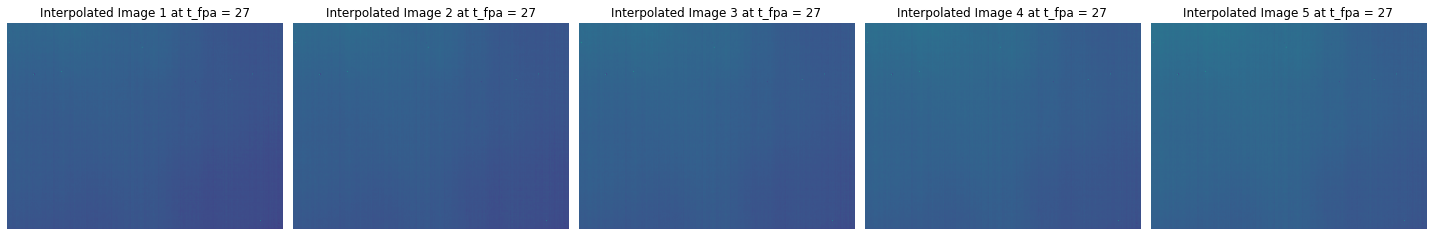

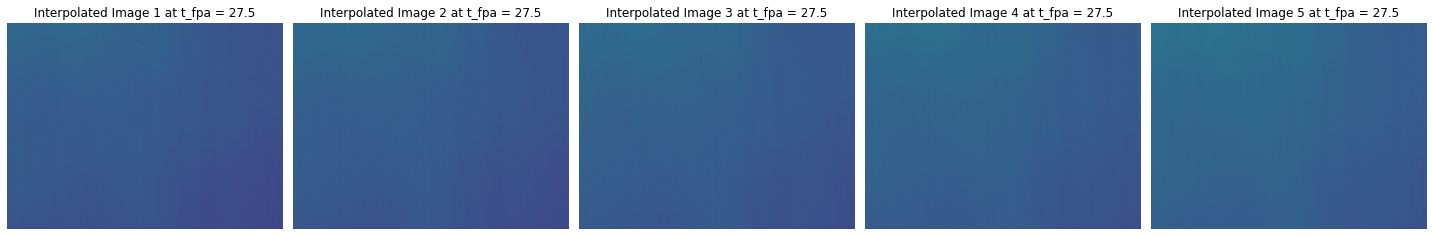

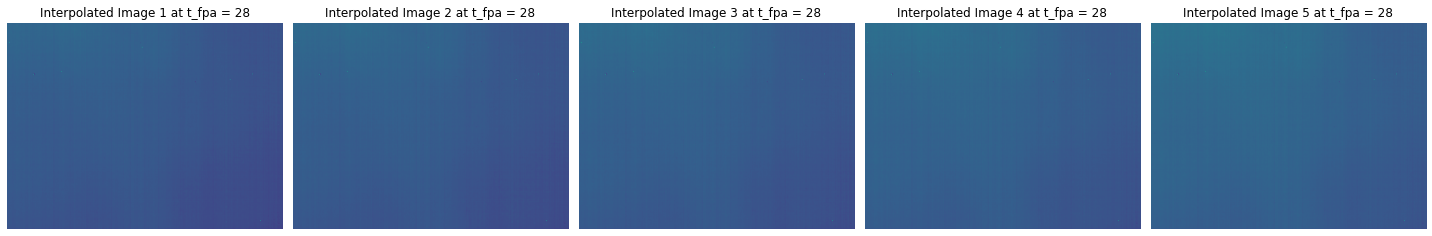

In [ ]:
target_t_fpa1 = 27
target_t_fpa2 = 27.5
target_t_fpa3 = 28

interpolated_images1 = interpolate_TargetTfpa(target_t_fpa1)
interpolated_images2 = interpolate_TargetTfpa(target_t_fpa2)
interpolated_images3 = interpolate_TargetTfpa(target_t_fpa3)

## **3. Apply a simplified afine model of raw images**

$Raw_{pixel}(t) = Resp_{pixel} \times S_{pixel}(t) + Offset_{pixel}$

- **$Raw_{pixel}(t)$**: At time t, the raw image data recorded by the sensor at a specific pixel location.
- **$Resp_{pixel}$**: The responsivity of the pixel, representing the sensitivity of the pixel to incoming infrared radiation.
- **$S_{pixel}(t)$**: The scene image data at the pixel location at time t (the true temperature or irradiance value we want to obtain).
- **$Offset_{pixel}$**: The offset at the pixel location, a fixed calibration parameter used to correct the inherent bias of the sensor.

**NUC 2 points correction:**

$S_{pixel}(t) = \frac{Raw_{pixel} - Offset_{pixel}}{Resp_{pixel}}$

It can also be expressed in an equivalent form (in terms of image quality):

$
\hat{S}(t) \propto (Raw(t) - Offset) \times Gain
$

where Gain is:

$
Gain = \frac{\mu_R}{\mu_{Resp}}
$

$μ_R$ and $μ_{Resp}$ are the average values of the Raw image and the Responsivity image, respectively.

Meanwhile, ${Resp_{pixel}} = \frac{ \Delta Raw_{pixel}}{ \Delta t_{cn}}$, $ Offset = Raw_{pixel} - Responsivity \cdot t_{cn} $

### **3.1 Calculate ${Resp_{pixel}}$ and $Offset$**

In [ ]:
delta_signal1 = interpolated_images1[4] - interpolated_images1[0]
delta_signal2 = interpolated_images2[4] - interpolated_images2[0]
delta_signal3 = interpolated_images3[4] - interpolated_images3[0]

delta_temp = 40. #(50 - 10)

In [ ]:
resp1 = delta_signal1 / delta_temp
offset1 = interpolated_images1[4] - 50. * resp1

resp2 = delta_signal2 / delta_temp
offset2 = interpolated_images1[4] - 50. * resp2

resp3 = delta_signal3 / delta_temp
offset3 = interpolated_images1[4] - 50. * resp3

### **3.2 Apply ${Resp_{pixel}}$ and $Offset$ to scene dataset**

In [ ]:
corrected_image_sequences1 = []

scene_image_index = 0

while scene_image_index < len(scene1_image):

    corrected_image1 = (scene1_image[scene_image_index] - offset1) / resp1

    corrected_image_sequences1.append(corrected_image1)

    scene_image_index += 1

C:\Users\student\AppData\Local\Temp\ipykernel_20236\3756994149.py:7: RuntimeWarning: invalid value encountered in divide
  corrected_image1 = (scene1_image[scene_image_index] - offset1) / resp1


In [ ]:
corrected_image_sequences2 = []

scene_image_index = 0

while scene_image_index < len(scene2_image):

    corrected_image2 = (scene2_image[scene_image_index] - offset2) / resp2

    corrected_image_sequences2.append(corrected_image2)

    scene_image_index += 1

C:\Users\student\AppData\Local\Temp\ipykernel_20236\1124418249.py:7: RuntimeWarning: invalid value encountered in divide
  corrected_image2 = (scene2_image[scene_image_index] - offset2) / resp2


In [ ]:
corrected_image_sequences3 = []

scene_image_index = 0

while scene_image_index < len(scene3_image):

    corrected_image3 = (scene3_image[scene_image_index] - offset3) / resp3

    corrected_image_sequences3.append(corrected_image3)

    scene_image_index += 1

C:\Users\student\AppData\Local\Temp\ipykernel_20236\2156326327.py:7: RuntimeWarning: invalid value encountered in divide
  corrected_image3 = (scene3_image[scene_image_index] - offset3) / resp3


### **3.3 Check images to make sure there's no NaN values**

In [ ]:
def replace_nans(image):
    if np.isnan(image).any():
        print("Detected NaNs, filling it.")
        nan_mask = np.isnan(image)  # Finding the NaN values
        mean_val = np.nanmean(image)  # Taking the mean of non-NaN values  #nearest neighbor / local median
        image[nan_mask] = mean_val  # Replacing with the mean of non-NaN values
    return image

corrected_image_sequences1 = [replace_nans(corrected_image1) for corrected_image1 in corrected_image_sequences1]
corrected_image_sequences2 = [replace_nans(corrected_image2) for corrected_image2 in corrected_image_sequences2]
corrected_image_sequences3 = [replace_nans(corrected_image3) for corrected_image3 in corrected_image_sequences3]

In [ ]:
print("min:", np.min(corrected_image1))
print("max:", np.max(corrected_image1))
print("mean:", np.mean(corrected_image1))
print("std:", np.std(corrected_image1))

min: 20.341612001301574
max: 31.270804822792613
mean: 23.44257929997793
std: 1.3511537991871414


In [ ]:
print("min:", np.min(corrected_image2))
print("max:", np.max(corrected_image2))
print("mean:", np.mean(corrected_image2))
print("std:", np.std(corrected_image2))

min: 20.0
max: 32.31814922522508
mean: 24.37973179326721
std: 2.0357324787143942


In [ ]:
# fix some outliers
for corrected_image2 in corrected_image_sequences2:

    corrected_image2[corrected_image2 < 21.] = 20.
    #corrected_image2[corrected_image2 > 25.] = 25.

In [ ]:
print("min:", np.min(corrected_image3))
print("max:", np.max(corrected_image3))
print("mean:", np.mean(corrected_image3))
print("std:", np.std(corrected_image3))

min: 19.0
max: 37.57748753102647
mean: 22.7622652042837
std: 1.0769111276834984


In [ ]:
# fix some outliers
for corrected_image3 in corrected_image_sequences3:

    corrected_image3[corrected_image3 < 19.] = 19
    #corrected_image3[corrected_image3 > 25.] = 25.

### **3.3 Check the result (corrected images)**

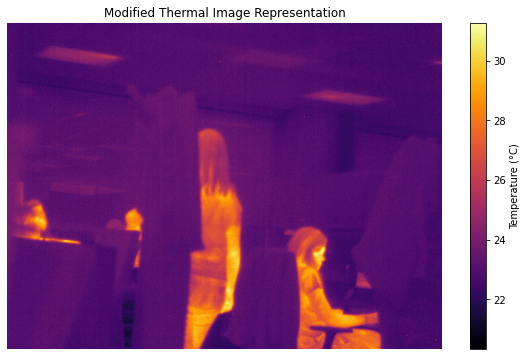

In [ ]:
plt.figure(figsize=(10, 6))
img = plt.imshow(corrected_image1, cmap='inferno')
plt.title("Modified Thermal Image Representation")
plt.axis('off')

cbar = plt.colorbar(img)
cbar.set_label('Temperature (°C)')

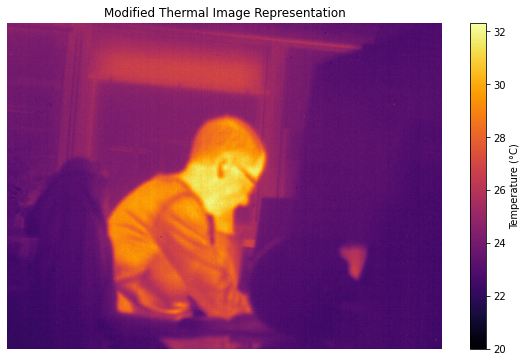

In [ ]:
plt.figure(figsize=(10, 6))
img = plt.imshow(corrected_image2, cmap='inferno')
plt.title("Modified Thermal Image Representation")
plt.axis('off')

cbar = plt.colorbar(img)
cbar.set_label('Temperature (°C)')

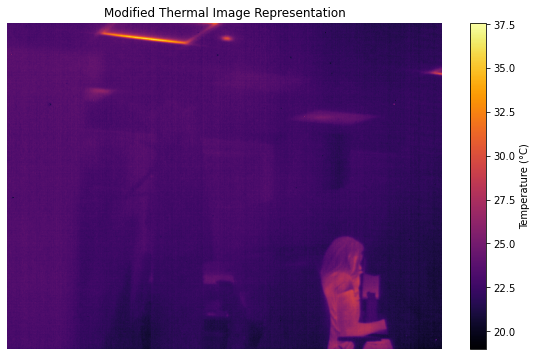

In [ ]:
plt.figure(figsize=(10, 6))
img = plt.imshow(corrected_image3, cmap='inferno')
plt.title("Modified Thermal Image Representation")
plt.axis('off')

cbar = plt.colorbar(img)
cbar.set_label('Temperature (°C)')

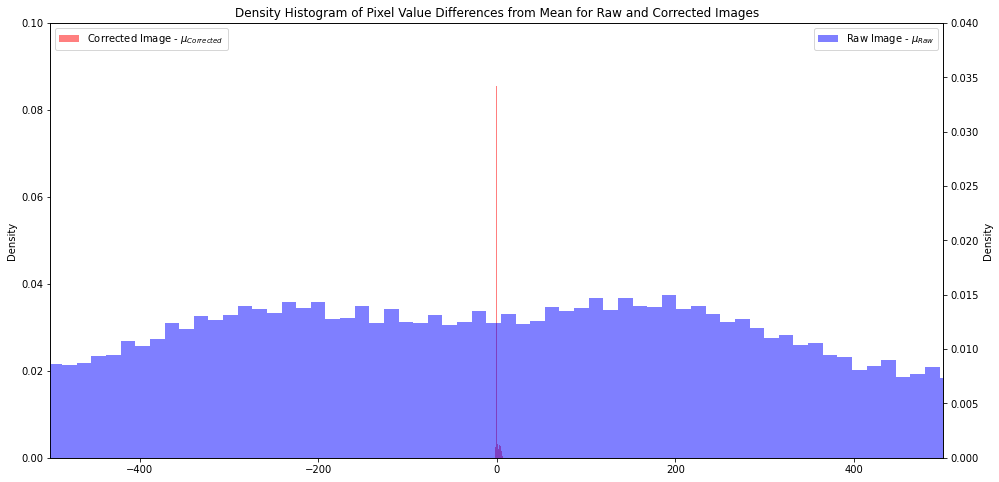

In [ ]:
selected_index = 399
raw_image = scene1_image[selected_index]
corrected_image = corrected_image_sequences1[selected_index]

# Calculate the differences from the mean for each image
corrected_diff = corrected_image - np.mean(corrected_image)
raw_diff = raw_image - np.mean(raw_image)

# Weights
weights1 = np.ones_like(corrected_diff.ravel()) / len(corrected_diff.ravel())
weights2 = np.ones_like(raw_diff.ravel()) / len(raw_diff.ravel())

# Plot histograms
plt.figure(figsize=(16, 8))

ax1 = plt.gca()
hist1 = ax1.hist(corrected_diff.ravel(), bins=100, alpha=0.5, color='red', label=r'Corrected Image - $\mu_{Corrected}$', weights = weights2)
ax1.set_ylim(0, 0.1)
ax1.set_ylabel('Density')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
hist2 = ax2.hist(raw_diff.ravel(), bins=1000, alpha=0.5, color='blue', label=r'Raw Image - $\mu_{Raw}$', weights = weights1)
ax2.set_ylim(0, 0.04)
ax2.set_ylabel('Density')
ax2.legend(loc='upper right')

plt.title('Density Histogram of Pixel Value Differences from Mean for Raw and Corrected Images')
plt.legend()
plt.xlim(-500, 500)
plt.show()

## **4. Export the results**

#### **4.1 Export an image sequence**

In [ ]:
output_dir = 'output_images_task1_inferno'
os.makedirs(output_dir, exist_ok=True)

for idx, corrected_image in enumerate(corrected_image_sequences1):
    plt.figure(figsize=(10, 6))
    img = plt.imshow(corrected_image, cmap='inferno')
    plt.title("Thermal Image Representation_inferno")
    plt.axis('off')

    cbar = plt.colorbar(img)
    cbar.set_label('Temperature (°C)')

    output_filename = os.path.join(output_dir, f'Task_1_inferno#{idx:04d}.png')
    plt.savefig(output_filename, bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.close()

In [ ]:
output_dir = 'output_images_task1_gray'
os.makedirs(output_dir, exist_ok=True)

for idx, corrected_image in enumerate(corrected_image_sequences1):
    plt.figure(figsize=(10, 6))
    img = plt.imshow(corrected_image, cmap='gray')
    plt.title("Thermal Image Representation_gray")
    plt.axis('off')

    cbar = plt.colorbar(img)
    cbar.set_label('Temperature (°C)')

    output_filename = os.path.join(output_dir, f'Task_1_gray#{idx:04d}.png')
    plt.savefig(output_filename, bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.close()

#### **4.2 Export a video**

In [ ]:
def replace_nans(image):
    if np.isnan(image).any():
        nan_mask = np.isnan(image) # finding the Nan values
        mean_val = np.nanmean(image) # taking the mean of non-Nan vlaues
        image[nan_mask] = mean_val # replacing with the mean of non-Nan values
    return image

# new sequences by clearing the Nan values
corrected_image_sequences_N = [replace_nans(image) for image in corrected_image_sequences1]


def create_video_from_images(corrected_image_sequences_N, output_filename='Task_1_gray.avi', fps=40):

    # Normalize images based on global min and max
    global_min_n = min(image.min() for image in corrected_image_sequences_N)
    global_max_n = max(image.max() for image in corrected_image_sequences_N)
    corrected_image_sequences_N = [(255 * (image - global_min_n) / (global_max_n - global_min_n)).astype(np.uint8) for image in corrected_image_sequences_N]

    # Get the size of the images
    height, width = corrected_image_sequences_N[0].shape[:2]
    size = (width, height)

    # Define the codec and create VideoWriter object
    out = cv2.VideoWriter(output_filename, cv2.VideoWriter_fourcc(*'DIVX'), fps, size, isColor=False)

    for image in corrected_image_sequences_N:
        out.write(image)

    # Release the VideoWriter
    out.release()

create_video_from_images(corrected_image_sequences_N)

In [ ]:
def replace_nans(image):
    if np.isnan(image).any():
        nan_mask = np.isnan(image)  # Finding the NaN values
        mean_val = np.nanmean(image)  # Taking the mean of non-NaN values
        image[nan_mask] = mean_val  # Replacing with the mean of non-NaN values
    return image

corrected_image_sequences_N = [replace_nans(image) for image in corrected_image_sequences1]

def create_video_from_images(images, output_filename='task_1_falsecolor.avi', fps=40):
    images_colored = []
    min_val = min([image.min() for image in images])
    max_val = max([image.max() for image in images])
    for image in images:
        # Normalize the image
        if max_val > min_val:
            normalized_image = (image - min_val) / (max_val - min_val)
        else:  # Avoid division by zero if all values are the same
            normalized_image = np.zeros_like(image)

        normalized_image = (255 * normalized_image).astype(np.uint8)  # Scale to 255 and convert to uint8

        # Apply COLORMAP_JET to the normalized image
        colored_image = cv2.applyColorMap(normalized_image, cv2.COLORMAP_JET)

        images_colored.append(colored_image)

    # Get the size of the images
    height, width = images_colored[0].shape[:2]
    size = (width, height)

    # Define the codec and create VideoWriter object with color
    out = cv2.VideoWriter(output_filename, cv2.VideoWriter_fourcc(*'DIVX'), fps, size, isColor=True)

    for image in images_colored:
        out.write(image)  # Write each frame to the video

    # Release the VideoWriter
    out.release()

create_video_from_images(corrected_image_sequences_N)